In [1]:
import bioframe as bf
from datasets import load_dataset
from gpn.data import GenomeMSA
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"""
from gpn.data import Genome

enformer = pd.read_parquet("../../results/enformer/merged.parquet")
genome = Genome("../../results/genome.fa.gz")
enformer["ref_nuc"] = enformer.progress_apply(lambda v: genome.get_nuc(v.chrom, v.pos).upper(), axis=1)
mask = enformer['ref'] != enformer['ref_nuc']
enformer.loc[mask, ['ref', 'alt']] = enformer.loc[mask, ['alt', 'ref']].values
enformer.to_parquet("../../results/enformer/merged.correct_ref_alt.parquet", index=False)
""";

In [3]:
# TODO: in the future can split train/val and test according to even/odd
# and just do 2 splits
TRAIN_CHROMS = [str(i) for i in range(1, 11)]
VALIDATION_CHROMS = ["11", "12"]
D = 768
features = [f"embedding_{i}" for i in range(D)]

In [4]:
models = [
    "CADD.RawScore",
    "phyloP",
    "phastCons",
    "phyloP-Zoonomia",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]
embedding_model = models[-1]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
}

V = load_dataset("../../results/gtex/merged", split="test").to_pandas()
d = Path(f"../../results/preds/results/gtex/merged")

for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,GPN-MSA
0,1,14677,G,A,True,-0.370660,-0.452,-0.000,-1.902,-1.095050
1,1,17730,C,A,False,-1.218470,-2.889,-1.000,-4.690,1.481261
2,1,54490,G,A,True,0.201295,0.313,-0.000,-0.029,0.039775
3,1,63671,G,A,True,-0.344458,1.392,-0.000,-0.253,3.129621
4,1,63697,T,C,True,-1.180623,-1.155,-0.701,-2.212,-6.382286
...,...,...,...,...,...,...,...,...,...,...
58405,X,155744353,G,T,True,0.158726,0.107,-0.001,-1.722,-0.079454
58406,X,155768650,G,T,True,-1.179355,-2.212,-1.000,-2.759,7.381042
58407,X,155768714,G,C,True,-0.088585,0.175,-0.640,-0.502,-3.618934
58408,X,155779999,A,C,False,0.076083,0.156,-0.000,0.200,-1.525492


In [5]:
V = pd.concat([
    V,
    pd.read_parquet(f"../../results/preds/vep_embedding/results/gtex/merged/{embedding_model}.parquet")
], axis=1)
V

,chrom,pos,ref,alt,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,GPN-MSA,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,1,14677,G,A,True,-0.370660,-0.452,-0.000,-1.902,-1.095050,...,89.838196,199.672211,77.431107,118.214149,76.438446,85.780685,116.801186,134.992523,98.798294,136.315735
1,1,17730,C,A,False,-1.218470,-2.889,-1.000,-4.690,1.481261,...,89.713486,146.122437,71.958832,127.378113,105.690369,146.376953,127.883156,86.037689,110.304382,148.695740
2,1,54490,G,A,True,0.201295,0.313,-0.000,-0.029,0.039775,...,78.218887,195.490768,65.736748,116.196938,37.669392,61.344448,66.525375,222.361511,86.355278,123.404312
3,1,63671,G,A,True,-0.344458,1.392,-0.000,-0.253,3.129621,...,60.808266,185.885147,56.572441,108.371582,48.275101,132.780823,117.328644,145.440216,78.304321,113.809845
4,1,63697,T,C,True,-1.180623,-1.155,-0.701,-2.212,-6.382286,...,54.700588,199.266296,62.107849,108.522766,44.507469,128.121628,97.487602,157.041504,88.587296,103.449051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58405,X,155744353,G,T,True,0.158726,0.107,-0.001,-1.722,-0.079454,...,57.104858,176.774933,72.009583,111.837677,52.309387,86.697060,71.960938,207.810165,105.583748,117.820549
58406,X,155768650,G,T,True,-1.179355,-2.212,-1.000,-2.759,7.381042,...,108.762115,68.121475,72.987350,104.171677,60.890697,148.558319,88.829399,97.425491,92.073380,120.274269
58407,X,155768714,G,C,True,-0.088585,0.175,-0.640,-0.502,-3.618934,...,102.985809,61.088684,77.131180,94.744843,62.962914,159.890121,122.761765,98.166855,117.757278,98.256119
58408,X,155779999,A,C,False,0.076083,0.156,-0.000,0.200,-1.525492,...,51.425179,167.560028,70.923637,137.495300,67.493050,99.918846,77.596214,244.060669,113.120598,108.227631


In [6]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

GPN-MSA


In [7]:
enformer = pd.read_parquet("../../results/enformer/merged.correct_ref_alt.parquet")
cols = ["chrom", "pos", "ref", "alt"]
V = V.merge(enformer, on=cols, how="inner")
models += [
    "Enformer_l2",
    #"Enformer_l1",
    #"Enformer_linf",
]
V

,chrom,pos,ref,alt,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,GPN-MSA,...,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,Enformer_l1,Enformer_l2,Enformer_linf,ref_nuc
0,1,54490,G,A,True,0.201295,0.313,-0.000,-0.029,-0.039775,...,37.669392,61.344448,66.525375,222.361511,86.355278,123.404312,-1.388672,-0.039154,-0.008972,G
1,1,63671,G,A,True,-0.344458,1.392,-0.000,-0.253,-3.129621,...,48.275101,132.780823,117.328644,145.440216,78.304321,113.809845,-5.425781,-0.119751,-0.015160,G
2,1,108230,C,T,True,-0.244932,0.480,-0.000,-0.118,-0.162981,...,59.881935,62.677105,35.060310,262.469727,128.727829,109.150986,-2.343750,-0.045624,-0.005436,C
3,1,135203,G,A,True,-0.183566,0.239,-0.000,0.338,-0.981487,...,40.877106,85.952293,51.371506,79.543945,43.016586,80.492035,-1.589844,-0.028915,-0.002449,G
4,1,263722,C,G,True,0.263589,2.308,-0.000,-0.586,-0.079175,...,85.976074,122.279617,222.493393,243.337738,242.634705,86.137978,-6.570312,-0.160400,-0.069763,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54393,9,138175111,A,G,False,-0.447451,-0.243,-0.180,1.593,-3.140078,...,63.530533,140.270294,96.961868,126.968872,82.814278,165.155060,-6.011719,-0.129883,-0.029022,A
54394,9,138181974,A,C,False,-0.365930,-0.221,-0.117,1.223,-2.610379,...,79.882507,91.263206,320.788513,345.249512,153.408325,70.301895,-2.466797,-0.046692,-0.006752,A
54395,9,138198178,A,C,False,-0.149840,1.131,-0.053,3.364,-0.731493,...,79.665512,83.797180,303.865906,331.087219,157.133484,69.321274,-3.267578,-0.065796,-0.008209,A
54396,9,138210807,T,A,True,0.009917,0.967,-0.000,0.336,-1.311008,...,59.335842,86.866348,69.095901,237.547241,73.296249,71.876511,-9.937500,-0.290283,-0.111389,T


In [8]:
V_train = V[V.chrom.isin(TRAIN_CHROMS)].copy()
V_validation = V[V.chrom.isin(VALIDATION_CHROMS)].copy()
V_test = V[(~V.chrom.isin(TRAIN_CHROMS)) & (~V.chrom.isin(VALIDATION_CHROMS))].copy()
len(V_train), len(V_validation), len(V_test)

(27804, 5019, 21575)

## Inner product

In [9]:
results_train = pd.DataFrame([
    [f, average_precision_score(V_train.label, -V_train[f])]
    for f in tqdm(features)
], columns=["Model", "AUPRC"]).sort_values("AUPRC", ascending=False)
results_train

100%|██████████| 768/768 [00:04<00:00, 183.28it/s]


,Model,AUPRC
112,embedding_112,0.486988
761,embedding_761,0.485115
501,embedding_501,0.481255
39,embedding_39,0.481202
457,embedding_457,0.474064
...,...,...
402,embedding_402,0.227796
608,embedding_608,0.226087
381,embedding_381,0.225017
173,embedding_173,0.224792


In [10]:
sorted_indices = results_train.Model.values
sorted_indices[:10]

array(['embedding_112', 'embedding_761', 'embedding_501', 'embedding_39',
       'embedding_457', 'embedding_243', 'embedding_661', 'embedding_276',
       'embedding_132', 'embedding_481'], dtype=object)

In [11]:
V_test["inner_product_select_dimensions"] = V_test[sorted_indices[:10]].sum(axis=1)
models.append("inner_product_select_dimensions")

In [12]:
V_test["inner_product"] = V_test[features].sum(axis=1)
models.append("inner_product")

## Logistic regression (sklearn)

In [13]:
clf = Pipeline([
    ('scaler', StandardScaler()),
    #('pca', PCA(n_components=64, random_state=42)),  # slightly worse performance
    ('linear', LogisticRegressionCV(
        random_state=42,
        class_weight="balanced",
        scoring="average_precision",
        n_jobs=8,
        max_iter=1000,
    ))
    #('linear', PLSRegression(n_components=40)),
])

clf_features = features.copy()
#clf_features.append("GPN-MSA")
#clf_features.append("Enformer_l2")
#clf_features = features_other.copy()

clf.fit(V_train[clf_features], V_train.label)
pred = -clf.predict_proba(V_test[clf_features])[:, 1]  # for classification
#pred = -clf.predict(V_test[clf_features])  # for regression
V_test["inner_product_logistic_regression"] = pred
if "inner_product_logistic_regression" not in models: models.append("inner_product_logistic_regression")

## Testing

In [14]:
def get_subtitle(n_pathogenic, n_benign):
    return f"n={n_pathogenic} vs. {n_benign}"

pos_prop = []

rows = []
V_c = V_test.dropna(subset=models)
n_pos, n_neg = (V_c.label==True).sum(), (V_c.label==False).sum()
subtitle = get_subtitle(n_pos, n_neg)
pos_prop.append(n_pos/(n_pos+n_neg))

for m in tqdm(models):
    AUROC = roc_auc_score(V_c.label==True, -V_c[m])
    AUPRC = average_precision_score(V_c.label==True, -V_c[m])
    rows.append([m, AUROC, AUPRC])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"])
results

100%|██████████| 9/9 [00:00<00:00, 103.61it/s]


,Model,AUROC,AUPRC
0,CADD,0.549856,0.390192
1,phyloP-100-vertebrates,0.524794,0.347160
2,phastCons-100-vertebrates,0.473918,0.330568
3,phyloP-241-mammals,0.529087,0.368536
4,GPN-MSA,0.545634,0.371334
5,Enformer_l2,0.682603,0.554759
6,inner_product_select_dimensions,0.661855,0.493994
7,inner_product,0.482629,0.309393
8,inner_product_logistic_regression,0.679204,0.508229


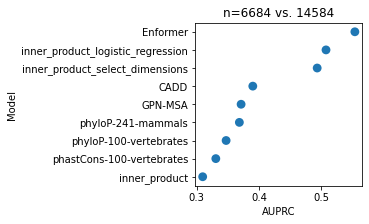

In [15]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.sort_values("AUPRC", ascending=False).replace("Enformer_l2", "Enformer"),
    y="Model",
    x="AUPRC",
    join=False,
)
plt.title(subtitle);